## NFL 2017 Hierarchical Model for American Football 
This work is based on the example on PyMC3 by Peadar Coyle
http://docs.pymc.io/notebooks/rugby_analytics.html
The model is referenced on 
http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/
Paper: Bayesian hierarchical model for the prediction of football results
http://www.statistica.it/gianluca/Research/BaioBlangiardo.pdf

Data of NFL 2017 score
https://www.pro-football-reference.com/years/2017/games.htm

There are 32 teams in the NFL. Team strength  (latent variable) can be inferred from observing the score. Probabilistic Programming is a way for modeling these latent parameters. 
<img src="hpgm.png">

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import pymc3 as pm, theano.tensor as tt

In [165]:
# Score from all games in 2017 season in format home_team, away_team, home_score, away_score
df = pd.read_csv('nfl2017_score.csv')

In [166]:
teams = df.home_team.unique()

In [167]:
# Create index, variables for future reference
teams = df.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

df = pd.merge(df, teams, left_on='home_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values

home_team = df.i_home.values
away_team = df.i_away.values
num_teams = len(df.i_home.drop_duplicates())
num_games = len(home_team)

# not used for pymc3 Normal distribution doesn't take starting point
g = df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean())

In [168]:
observed_home_goals

array([27, 17,  7, 35, 16, 17, 18, 21,  0, 46, 17,  3, 19, 29, 24,  9, 20,
       13, 29, 16, 26, 27, 24,  9, 17, 45, 20, 42, 12, 34, 10, 39, 44, 20,
       26, 34, 31, 26, 36, 23, 13, 27, 33, 10, 27, 27, 17, 35,  0,  9, 30,
       17,  7,  7, 57, 30, 23, 25, 24, 18, 16, 46, 29, 14, 16,  9, 34, 14,
       24, 20, 22, 26, 17, 10, 31, 34, 17, 23, 17, 24, 23, 52, 26, 33, 17,
       17, 38, 16, 13, 10, 36, 31, 30, 31, 17, 24,  0, 33, 17,  9, 10, 29,
       21,  7, 23, 34, 40, 16, 34, 20, 24, 21,  3, 20, 33, 41, 19, 15, 29,
       34, 17, 51, 20, 30, 23, 23, 14, 10, 14, 28, 24, 17, 16, 38, 30, 10,
       20, 24, 16, 15, 17, 33, 31, 27, 16, 45, 40,  0, 24, 12, 31, 20, 34,
        7, 24, 54, 17,  8,  9, 31, 23,  6, 20, 16, 10, 34, 30, 31, 27, 35,
       13, 26, 27, 21, 31, 23, 38, 35, 24, 30,  3,  9, 38, 26, 44, 14, 19,
       16, 31, 24, 24, 20, 20, 10,  7, 21, 31, 16, 13, 26, 21, 12, 23, 30,
       30, 35, 39, 27, 13, 20, 30, 34, 24, 29, 31, 10, 20, 31, 45,  7, 25,
       24, 17, 21, 23,  0

In [169]:
teams

,team,i
0,NE,0
1,WAS,1
2,HOU,2
3,DET,3
4,TEN,4
5,CHI,5
6,CLE,6
7,BUF,7
8,CIN,8
9,LA,9


In [170]:
g.describe()

away_score  home_score     i_away
i_home                                         
0      count    8.000000    8.000000   8.000000
       mean    20.875000   29.375000  19.875000
       std     13.389095    6.116430  10.190156
       min      6.000000   21.000000   2.000000
       25%     11.500000   25.250000  16.750000
       50%     16.500000   28.500000  22.500000
       75%     33.000000   35.250000  26.500000
       max     42.000000   37.000000  31.000000
1      count    8.000000    8.000000   8.000000
       mean    21.375000   23.250000  20.000000
       std     11.338147    4.773438   8.246211
       min     10.000000   17.000000  11.000000
       25%     10.750000   19.750000  12.750000
       50%     19.500000   23.000000  19.000000
       75%     30.750000   27.000000  27.500000
       max     38.000000   30.000000  30.000000
2      count    8.000000    8.000000   8.000000
       mean    25.375000   24.750000  15.500000
       std      9.349370   17.285419   8.383658
       min     14.000000    6.000000   4.000000
       25%     19.250000   12.250000   9.750000
       50%     23.500000   23.500000  17.000000
       75%     30.250000   33.250000  19.250000
       max     42.000000   57.000000  30.000000
3      count    8.000000    8.000000   8.000000
       mean    21.875000   27.000000  16.375000
       std      7.809106    8.176622   9.303417
       min     10.000000   15.000000   5.000000
       25%     17.750000   22.250000   9.000000
       50%     23.500000   25.000000  16.000000
...                  ...         ...        ...
28     std      9.165151    9.794313  10.155048
       min      6.000000    7.000000   0.000000
       25%     18.500000   19.250000  15.250000
       50%     22.500000   21.500000  21.000000
       75%     26.500000   28.750000  23.750000
       max     35.000000   38.000000  31.000000
29     count    8.000000    8.000000   8.000000
       mean    13.375000   28.625000  15.500000
       std      8.814558   14.628128  10.488088
       min      3.000000    0.000000   1.000000
       25%      6.750000   25.000000   9.500000
       50%     10.000000   32.000000  13.000000
       75%     23.250000   34.000000  24.750000
       max     24.000000   51.000000  30.000000
30     count    8.000000    8.000000   8.000000
       mean    20.125000   20.875000  15.375000
       std     11.897629    8.322731   7.909082
       min      0.000000   12.000000   4.000000
       25%     13.000000   16.000000  10.500000
       50%     23.000000   17.500000  14.500000
       75%     29.000000   24.000000  19.750000
       max     33.000000   38.000000  27.000000
31     count    8.000000    8.000000   8.000000
       mean    20.750000   21.125000  13.625000
       std      7.869471   10.907894   9.635315
       min      9.000000    0.000000   0.000000
       25%     17.500000   16.000000   6.250000
       50%     21.000000   22.000000  14.500000
       75%     27.250000   28.000000  18.750000
       max     30.000000   35.000000  28.000000

[256 rows x 3 columns]

In [171]:
att_starting_points

i_away
0     3.327730
1     2.970414
2     2.862201
3     3.188417
4     2.862201
5     2.674149
6     2.803360
7     2.869318
8     2.957511
9     3.488903
10    3.119055
11    2.970414
12    3.119055
13    3.135494
14    2.682732
15    3.253277
16    2.748872
17    3.091042
18    3.178054
19    3.113515
20    3.323236
21    3.119055
22    3.050457
23    2.931194
24    2.724580
25    3.038552
26    3.073850
27    2.716349
28    2.639057
29    3.349904
30    2.772589
31    2.639057
Name: away_score, dtype: float64

In [172]:
def_starting_points

i_home
0    -3.038552
1    -3.062222
2    -3.233764
3    -3.085344
4    -3.026504
5    -2.795756
6    -3.151667
7    -3.008155
8    -3.001963
9    -2.970414
10   -3.008155
11   -3.336659
12   -3.167583
13   -2.525729
14   -2.989463
15   -3.113515
16   -3.068053
17   -2.917771
18   -2.833213
19   -3.151667
20   -2.825833
21   -2.904165
22   -3.056357
23   -2.756840
24   -3.119055
25   -3.188417
26   -2.818398
27   -3.262893
28   -3.091042
29   -2.593387
30   -3.001963
31   -3.032546
Name: away_score, dtype: float64

In [150]:
num_teams

32

In [151]:
model = pm.Model()
with pm.Model() as model:
    # global model parameters - prior 
    home = pm.Flat('home')
    sd_att = pm.HalfStudentT('sd_att', nu=7, sd=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=7, sd=2.5)
    intercept = pm.Flat('intercept')

    # team-specific model parameters
    
    atts_star = pm.Normal("atts_star", mu=0, sd=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sd=sd_def, shape=num_teams)

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -2,401.4: 100%|███████████████████████████████████████████████| 200000/200000 [01:37<00:00, 2059.27it/s]
Finished [100%]: Average ELBO = -2,401.4
100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:52<00:00, 178.32it/s]


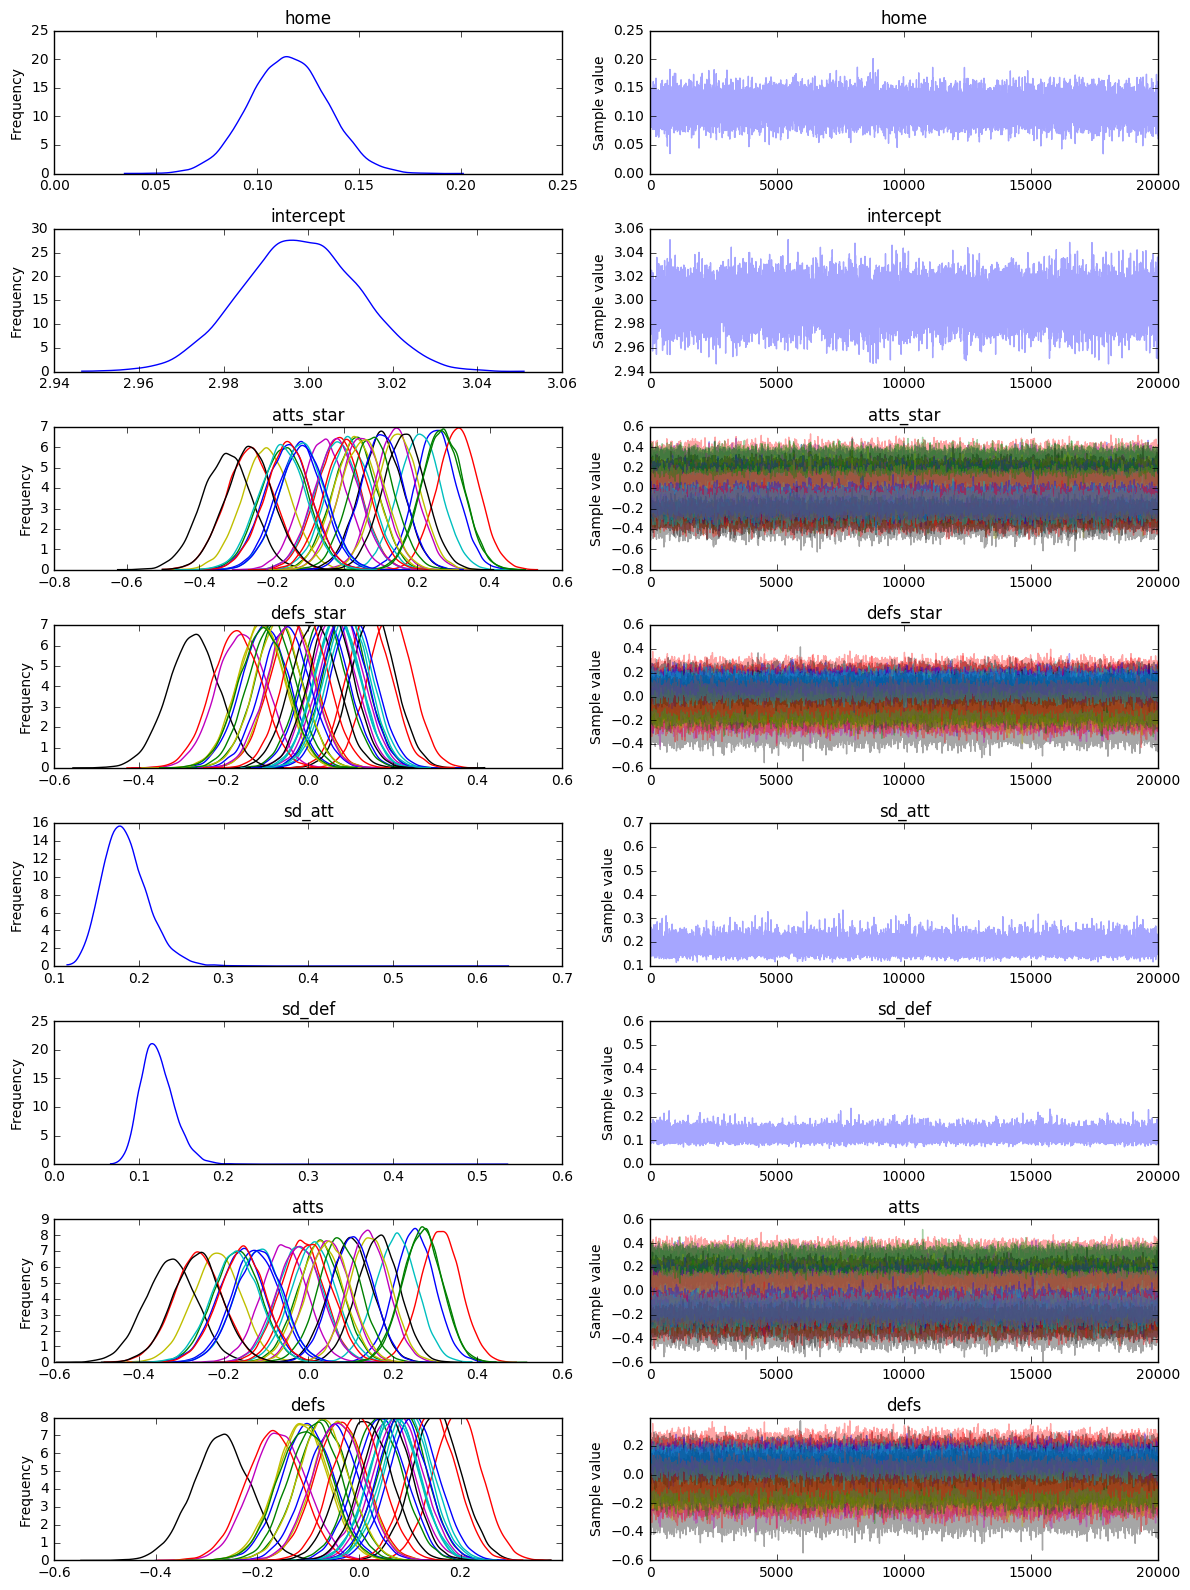

In [152]:
niter = 20000
with model:
    trace = pm.sample(niter, tune=1000)
    pm.traceplot(trace)

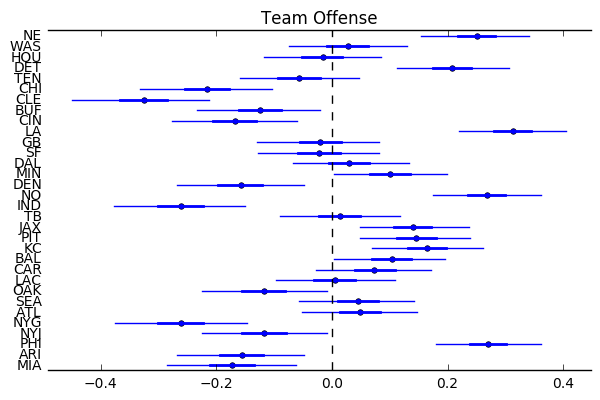

In [153]:
labels = teams['team']
pm.forestplot(trace, varnames=['atts'], ylabels=labels, main="Team Offense")

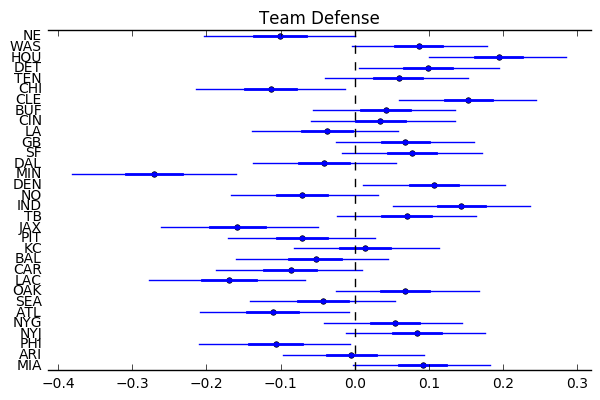

In [154]:
pm.forestplot(trace, varnames=['defs'], ylabels=labels, main="Team Defense")

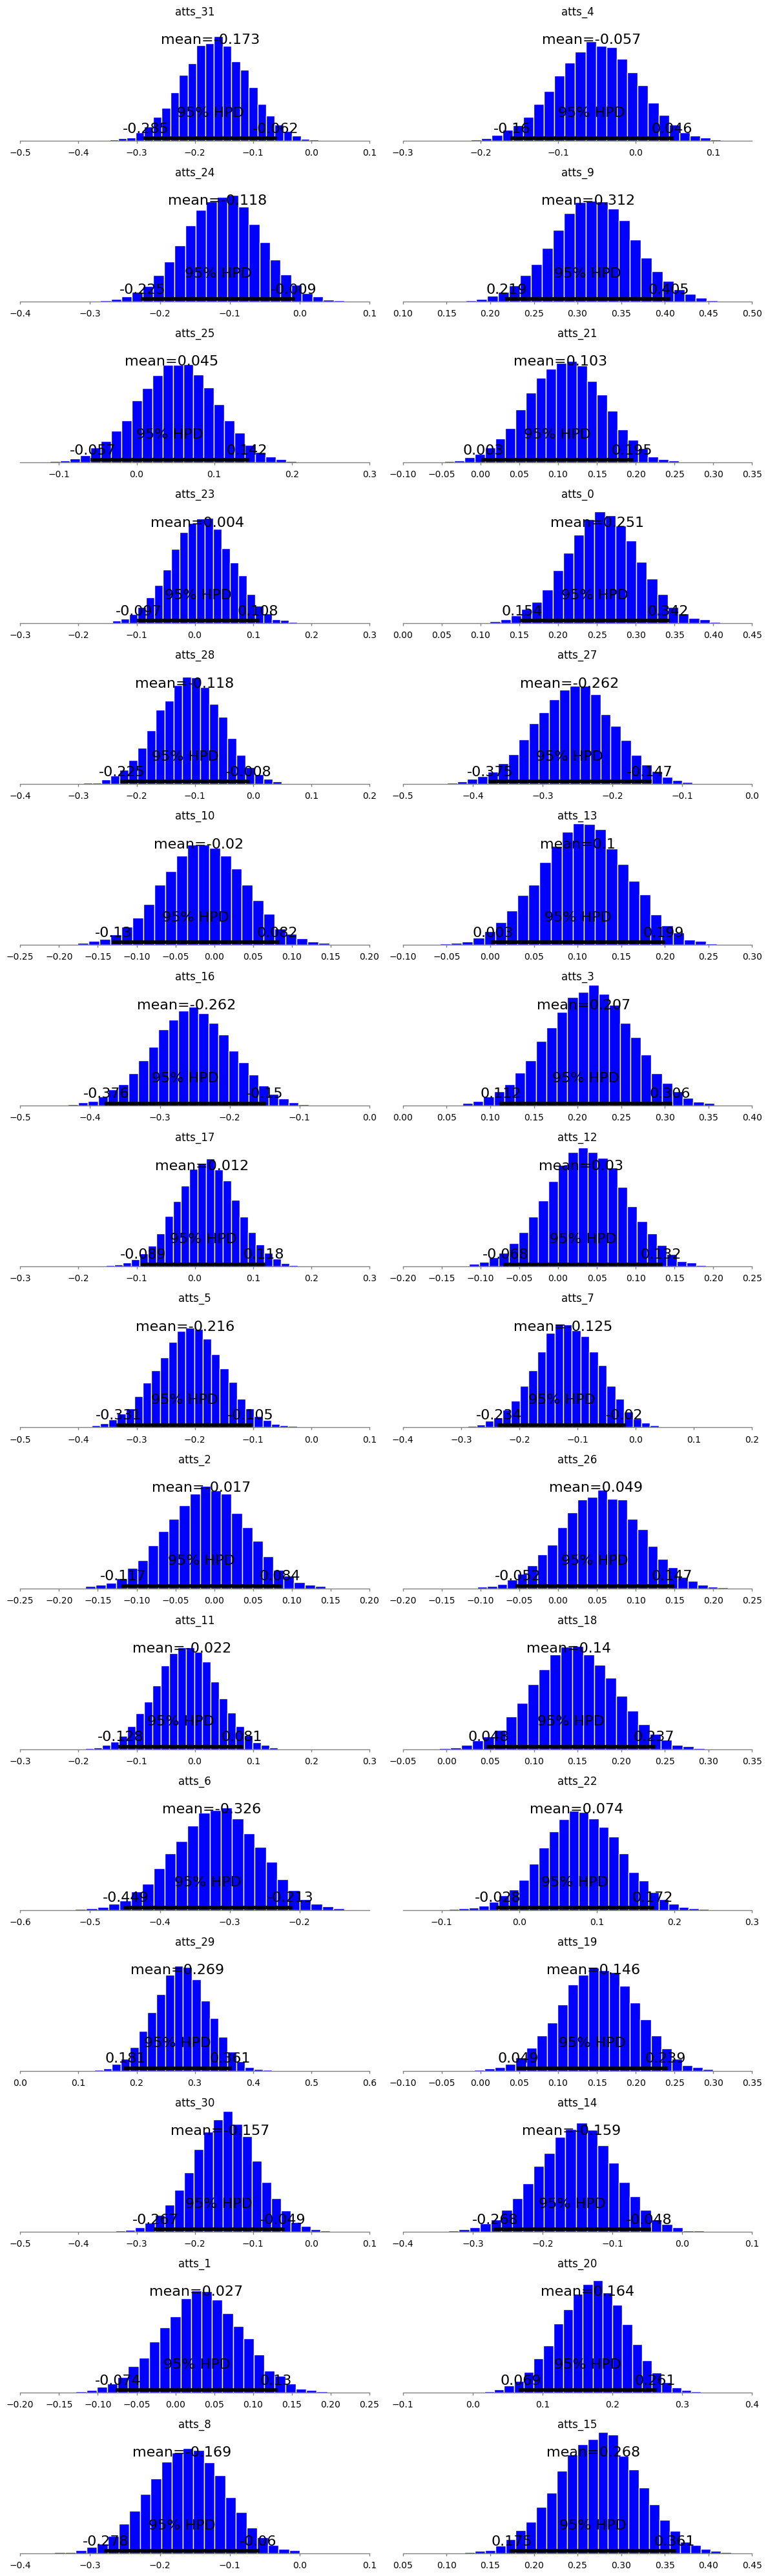

In [155]:
pm.plot_posterior(trace, varnames=['atts']);

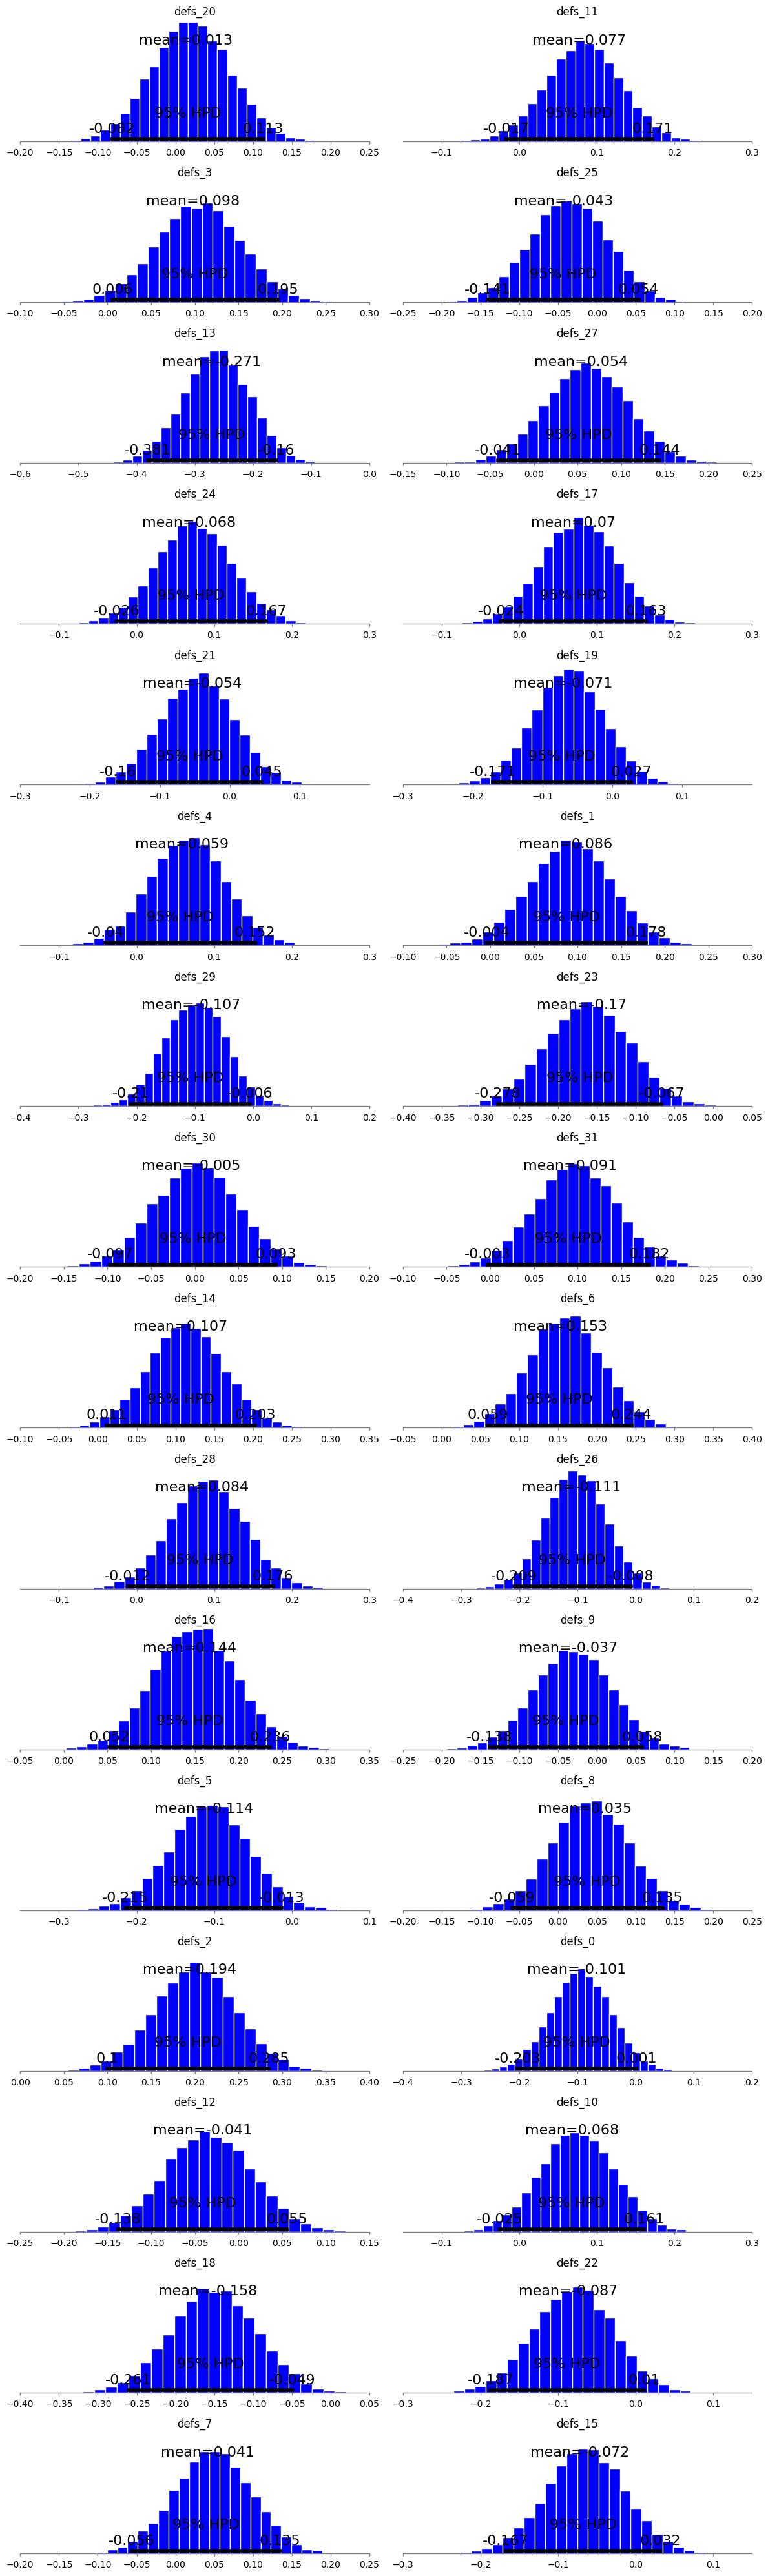

In [156]:
pm.plot_posterior(trace, varnames=['defs']);

In [157]:
pm.summary(trace, ['atts'])


atts:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.251            0.048            0.000            [0.154, 0.342]
  0.027            0.052            0.000            [-0.074, 0.130]
  -0.017           0.052            0.000            [-0.117, 0.084]
  0.207            0.049            0.000            [0.112, 0.306]
  -0.057           0.053            0.000            [-0.160, 0.046]
  -0.216           0.058            0.000            [-0.331, -0.105]
  -0.326           0.061            0.000            [-0.449, -0.213]
  -0.125           0.055            0.000            [-0.234, -0.020]
  -0.169           0.056            0.000            [-0.278, -0.060]
  0.312            0.047            0.000            [0.219, 0.405]
  -0.020           0.054            0.000            [-0.130, 0.082]
  -0.022           0.053            0.000            [-0.128, 0.081]
  0.030            0

In [158]:
trace['atts'].mean(axis=0)

array([ 0.25056694,  0.02684282, -0.01664121,  0.20712341, -0.05726351,
       -0.21624781, -0.32637802, -0.12534502, -0.16872965,  0.31227908,
       -0.02020017, -0.02224464,  0.02980574,  0.10028135, -0.15916042,
        0.2678749 , -0.26178839,  0.01240746,  0.13961909,  0.14555886,
        0.16414574,  0.10312179,  0.07368255,  0.00439657, -0.11783473,
        0.0451318 ,  0.04878565, -0.26186845, -0.11753758,  0.26941914,
       -0.15651758, -0.17328572])

In [159]:
df_avg = pd.DataFrame({'avg_att': trace['atts'].mean(axis=0),
                       'avg_def': trace['defs'].mean(axis=0)}, 
                      index=teams.team.values)

In [128]:
df_avg

,avg_att,avg_def
NE,0.269269,-0.077094
WAS,0.052170,0.055285
HOU,0.008403,0.193122
DET,0.201701,0.130374
TEN,-0.044354,0.095844
CHI,-0.215893,-0.121307
CLE,-0.376456,0.157988
BUF,-0.138742,0.048698
CIN,-0.223620,0.029365
LA,0.353425,-0.083417


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


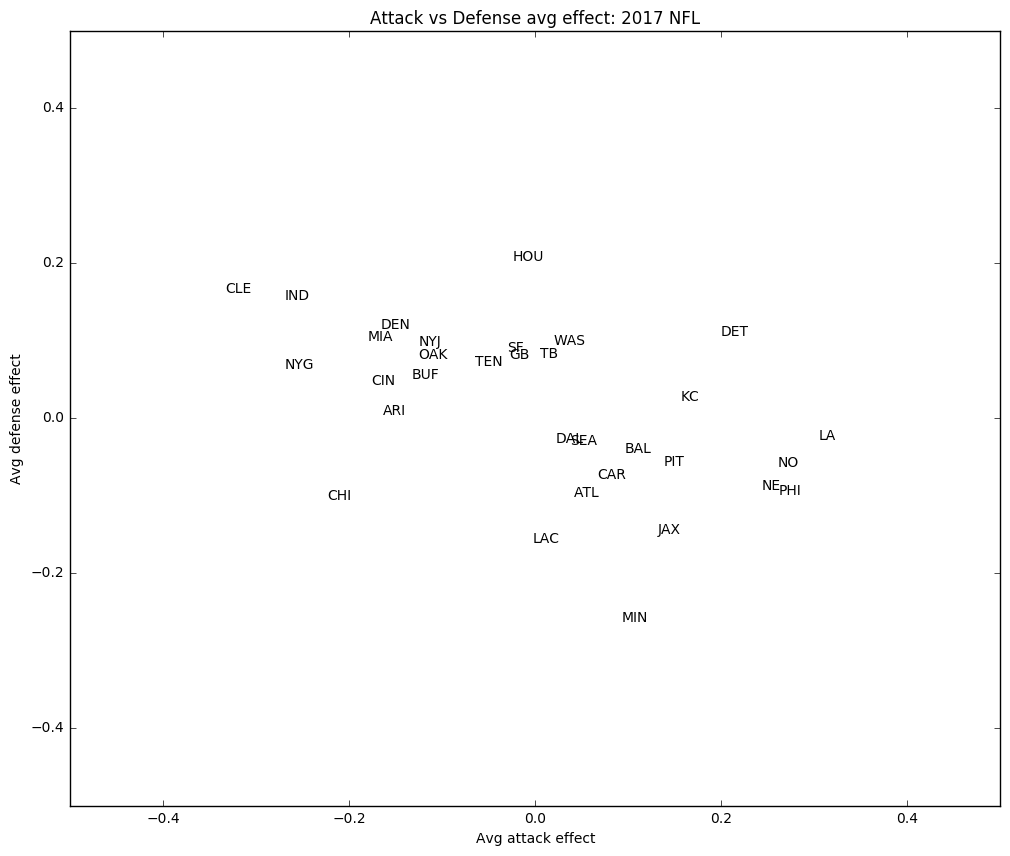

In [160]:
fig, ax = plt.subplots(figsize=(12,10))
plt.ylim([-0.5,0.5])
plt.xlim([-0.5,0.5])

for label, x, y in zip(teams.team.values, df_avg.avg_att.values, df_avg.avg_def.values):
    ax.annotate(label, xy=(x,y), xytext = (-5,5), textcoords = 'offset points')
    
ax.set_title('Attack vs Defense avg effect: 2017 NFL')
ax.set_xlabel('Avg attack effect')
ax.set_ylabel('Avg defense effect')
ax.legend()

In [173]:
def simulate_season():
    """
    Simulate a season once, using one random draw from the mcmc chain. 
    """
    num_samples = atts.trace().shape[0]
    draw = np.random.randint(0, num_samples)
    atts_draw = pd.DataFrame({'att': atts.trace()[draw, :],})
    defs_draw = pd.DataFrame({'def': defs.trace()[draw, :],})
    home_draw = home.trace()[draw]
    intercept_draw = intercept.trace()[draw]
    season = df.copy()
    season = pd.merge(season, atts_draw, left_on='i_home', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_home', right_index=True)
    season = season.rename(columns = {'att': 'att_home', 'def': 'def_home'})
    season = pd.merge(season, atts_draw, left_on='i_away', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_away', right_index=True)
    season = season.rename(columns = {'att': 'att_away', 'def': 'def_away'})
    season['home'] = home_draw
    season['intercept'] = intercept_draw
    season['home_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['home'] + 
                                                           x['att_home'] + 
                                                           x['def_away']), axis=1)
    season['away_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['att_away'] + 
                                                           x['def_home']), axis=1)
    season['home_goals'] = season.apply(lambda x: np.random.poisson(x['home_theta']), axis=1)
    season['away_goals'] = season.apply(lambda x: np.random.poisson(x['away_theta']), axis=1)
    season['home_outcome'] = season.apply(lambda x: 'win' if x['home_goals'] > x['away_goals'] else 
                                                    'loss' if x['home_goals'] < x['away_goals'] else 'draw', axis=1)
    season['away_outcome'] = season.apply(lambda x: 'win' if x['home_goals'] < x['away_goals'] else 
                                                    'loss' if x['home_goals'] > x['away_goals'] else 'draw', axis=1)
    season = season.join(pd.get_dummies(season.home_outcome, prefix='home'))
    season = season.join(pd.get_dummies(season.away_outcome, prefix='away'))
    return season


def create_season_table(season):
    """
    Using a season dataframe output by simulate_season(), create a summary dataframe with wins, losses, goals for, etc.
    
    """
    g = season.groupby('i_home')    
    home = pd.DataFrame({'home_goals': g.home_goals.sum(),
                         'home_goals_against': g.away_goals.sum(),
                         'home_wins': g.home_win.sum(),
                         'home_draws': g.home_draw.sum(),
                         'home_losses': g.home_loss.sum()
                         })
    g = season.groupby('i_away')    
    away = pd.DataFrame({'away_goals': g.away_goals.sum(),
                         'away_goals_against': g.home_goals.sum(),
                         'away_wins': g.away_win.sum(),
                         'away_draws': g.away_draw.sum(),
                         'away_losses': g.away_loss.sum()
                         })
    df = home.join(away)
    df['wins'] = df.home_wins + df.away_wins
    df['draws'] = df.home_draws + df.away_draws
    df['losses'] = df.home_losses + df.away_losses
    df['points'] = df.wins * 3 + df.draws
    df['gf'] = df.home_goals + df.away_goals
    df['ga'] = df.home_goals_against + df.away_goals_against
    df['gd'] = df.gf - df.ga
    df = pd.merge(teams, df, left_on='i', right_index=True)
    df = df.sort_index(by='points', ascending=False)
    df = df.reset_index()
    df['position'] = df.index + 1
    df['champion'] = (df.position == 1).astype(int)
    df['qualified_for_CL'] = (df.position < 5).astype(int)
    df['relegated'] = (df.position > 17).astype(int)
    return df  
    
def simulate_seasons(n=100):
    dfs = []
    for i in range(n):
        s = simulate_season()
        t = create_season_table(s)
        t['iteration'] = i
        dfs.append(t)
    return pd.concat(dfs, ignore_index=True)

In [174]:
simuls = simulate_seasons(1000)

TypeError: ('ExtractDiag only works on matrices', atts)

In [ ]:
ax = simuls.points[simuls.team == 'PIT'].hist(figsize=(7,5))
median = simuls.points[simuls.team == 'PIT'].median()
ax.set_title('Steelers:  1000 simulations')
ax.plot([median, median], ax.get_ylim())
plt.annotate('Median: %s' % median, xy=(median + 1, ax.get_ylim()[1]-10))